# Sensibilty Model for sill detection with fixed physical property and differents thickness and depth top.

In [1]:
%matplotlib inline

In [2]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LogNorm

In [10]:
# rho = resistivity array (ohm.m)
# N = number of layers
# h = thickness of layers (m)
# w = intrinsic impedance for each layer (gamma*rho)
# Z = impedance layer
# e = exp(-2*gamma*thickness)
# R = reflection coeff at interface j
# rhoa = computed app. resistivity; phi = phase of z1
# mu0 = magnetic permeability = 4.*PI*1.0E-7 (H/m)
# omega = angular frequeny (Hz)

 
p0 = [50.0, 5000, 200, 30.0]
#N = 24

In [11]:
class MTfwrd:
    
    def __init__(self, p0=[50.0, 5000, 200, 30.0], top=840, hs=400, base_depth=2500.0, \
                 z0 = 0.0, N=36, M = len(p0),ZZ=numpy.zeros(36, dtype = 'complex')):
        self.z0 = z0
        self.base_depth = base_depth
        self.top = top
        self.hs = hs
        self.p0 = numpy.array(p0, dtype = 'float')
        self.N = N
        self.M = M
        self.ZZ = ZZ

        self.f = numpy.logspace(-3.0, 3.0, num=self.N)
        T = 1.0/self.f
        self.omega = 2.*self.f*numpy.pi
        self.mu0 = 4.0*numpy.pi*1E-7
        self.im = (0.0+1.0j)
        self.h = numpy.zeros(M)
        self.h[0] = self.top - self.z0
        self.h[1] = self.hs
        self.h[2] = self.base_depth-self.h[0]-self.h[1]
        self.h[3] = 5000
        
        for k in range(self.N):
            gamma = numpy.sqrt((self.omega[k]*self.mu0*self.im)/p0[-1])
            w = gamma*p0[-1]
            Z = w
    
            for i in range(self.M-1):
                j = M-i-2
                gamma = numpy.sqrt((self.omega[k]*self.mu0*self.im)/p0[j])
                w = gamma*p0[j]
                R = (w - Z)/(w + Z)
                e = numpy.exp(-2.0*gamma*self.h[j])
                Z = w * ((1.0-R*e)/(1.0+R*e))
            ZZ[k] = Z
#        print self.h
 
    
    def Impedance(self, htop, hs, base_depth=2500.0):
        '''This function calculates the impedance tensor for 
        a given vector of frequencies (omega) and a given
        vector of resitivities (p0). You must give the depth of the top 
        of the sill layer and the thickness of the sill layer. The basement
        depth default value is 2380m'''
        
        h = self.h
        h[0] = htop - self.z0
        h[1] = hs
        h[2] = base_depth-h[0]-h[1]
        h[3] = 5000 
        
        M = self.M
        N = self.N
        ZZ = self.ZZ
        f = self.f
        omega = self.omega
        mu0 = self.mu0
        im = self.im
        p0 = self.p0

        for k in range(N):
            gamma = numpy.sqrt((omega[k]*mu0*im)/p0[-1])
            w = gamma*p0[-1]
            Z = w
    
            for i in range(M-1):
                j = M-i-2
                gamma = numpy.sqrt((omega[k]*mu0*im)/p0[j])
                w = gamma*p0[j]
                R = (w - Z)/(w + Z)
                e = numpy.exp(-2.0*gamma*h[j])
                Z = w * ((1.0-R*e)/(1.0+R*e))

            ZZ[k] = Z

        return ZZ

    def curves(self, Zcalc):
    
        h = self.h
        p0 = self.p0
        omega = self.omega
        mu0 = self.mu0
        im = self.im
        rhoap = (((omega*mu0)**-1.0)*(abs(Zcalc)**2))
        phase = numpy.arctan(Zcalc.imag/Zcalc.real)
        phi = (phase*180)/numpy.pi
    
        return rhoap, phi
    
    def multiplicative_noise(self, v, mu=0, sigma=0.01):
        '''This function assigns a Gaussian error with zero mean
        a given standard deviation to the input vector v.'''
        
        numpy.random.seed(10) 
        N = len(v)
        s = numpy.random.normal(mu, sigma, N)
        vnoise = (v+(s*v))
        
        return vnoise
    
    def additive_noise(self, v, mu=0, sigma=0.01):
        '''This function assigns a Gaussian error with zero mean
        a given standard deviation to the input vector v.'''
        
        numpy.random.seed(10) 
        N = len(v)
        s = numpy.random.normal(mu, sigma, N)
        vnoise = v+s
        
        return vnoise
    
    def phi(self, vobs, vcalc, lognorm=True):
        
        N = len(vobs)
        if lognorm:
            phi = (numpy.linalg.norm(numpy.log10(vobs) - numpy.log10(vcalc))**2)/N
            
        else:
            phi = (numpy.linalg.norm(vobs - vcalc)**2)/N
        
        return phi
    

    

In [12]:
# Reference Model:
#The reference model is based on borehole information and will be considered as the ground-truth.
# MT data calculated from this model will be considered as real data and will serve as reference to new synthetic ones

classe = MTfwrd()
Zref = classe.ZZ
rhoap, phi = classe.curves(Zref)

Zobs = classe.multiplicative_noise(Zref)
rhoap_obs = classe.multiplicative_noise(rhoap)
phi_obs = classe.additive_noise(phi)
#rhoap_obs, phi_obs = classe.curves(Zobs)

T = 1/classe.omega

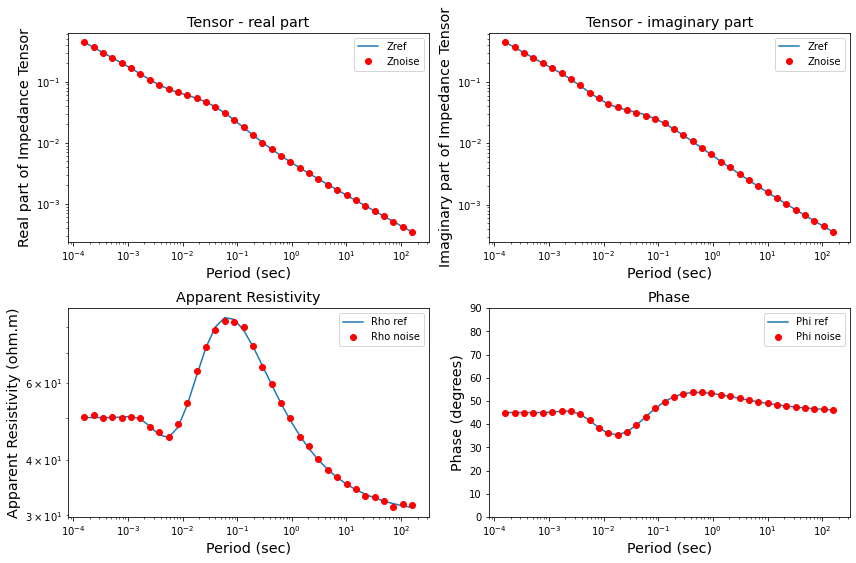

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(T, Zref.real, T, Zobs.real, 'ro')
plt.title('Tensor - real part', fontsize='x-large')
plt.legend(('Zref','Znoise'),numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period (sec)',fontsize='x-large')
plt.ylabel('Real part of Impedance Tensor',fontsize='x-large')

plt.subplot(2,2,2)
plt.plot(T, Zref.imag, T, Zobs.imag, 'ro')
plt.title('Tensor - imaginary part', fontsize='x-large')
plt.legend(('Zref','Znoise'),numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period (sec)',fontsize='x-large')
plt.ylabel('Imaginary part of Impedance Tensor',fontsize='x-large')

plt.subplot(2,2,3)
plt.plot(T, rhoap, T, rhoap_obs, 'ro')
plt.title('Apparent Resistivity', fontsize='x-large')
plt.legend(('Rho ref','Rho noise'), loc=0,numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period (sec)',fontsize='x-large')
plt.ylabel('Apparent Resistivity (ohm.m)',fontsize='x-large')

plt.subplot(2,2,4)
plt.plot(T, phi, T, phi_obs, 'ro')
plt.title('Phase', fontsize='x-large')
plt.legend(('Phi ref','Phi noise'),numpoints = 1)
plt.ylim([0, 90])
plt.xscale('log')
plt.xlabel('Period (sec)',fontsize='x-large')
plt.ylabel('Phase (degrees)',fontsize='x-large')

plt.tight_layout()
plt.show()

In [14]:
top_sill = numpy.linspace(50.0, 2500.0, 50) 
h_sill = numpy.linspace(50.0, 1000.0, 50)

x, y = numpy.meshgrid(top_sill, h_sill)
Phi1 = numpy.zeros(x.shape)
Phi2 = numpy.zeros(x.shape)
Phi3 = numpy.zeros(x.shape)
Phi4 = numpy.zeros(x.shape)

In [15]:
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        Z1 = classe.Impedance(x[i][j], y[i][j])
        Zcalc = classe.multiplicative_noise(Z1)
        rho_calc, phi_calc = classe.curves(Z1)
        rho_calc1 = classe.multiplicative_noise(rho_calc)
        phi_calc1 = classe.additive_noise(phi_calc)
        #rho_calc1, phi_calc1 = classe.curves(Zcalc)
        Phi1[i][j] = classe.phi(Zobs, Zcalc)
        Phi2[i][j] = classe.phi(Zobs.imag, Zcalc.imag)
        Phi3[i][j] = classe.phi(rhoap_obs, rho_calc1)
        Phi4[i][j] = classe.phi(phi_obs, phi_calc1, lognorm=False)

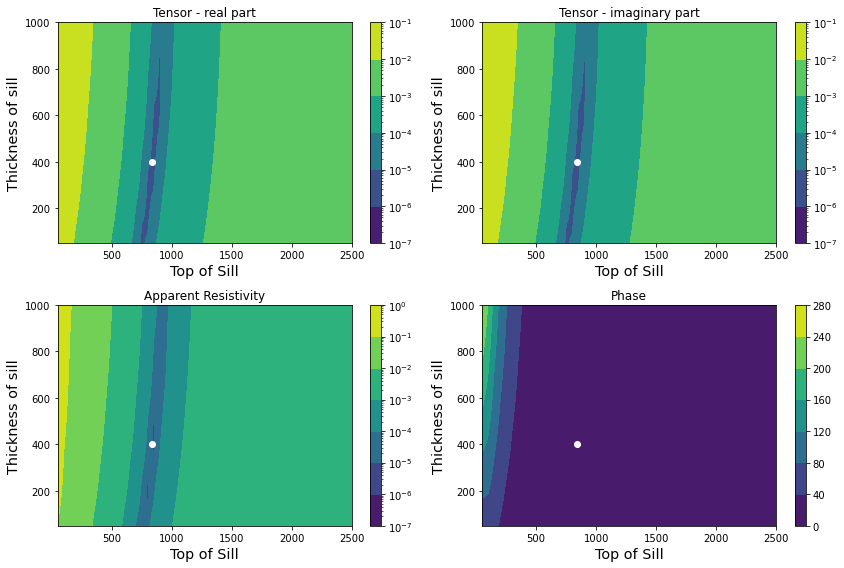

In [16]:
nlevels = 30

plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
plt.contourf(x, y, Phi1,nlevels, norm=LogNorm())
plt.colorbar()
plt.plot(classe.top, classe.hs, 'wo')
plt.title('Tensor - real part')
plt.xlabel('Top of Sill', fontsize='x-large')
plt.ylabel('Thickness of sill', fontsize='x-large')

plt.subplot(2, 2, 2)
plt.contourf(x, y, Phi2, norm=LogNorm())
plt.colorbar()
plt.plot(classe.top, classe.hs, 'wo')
plt.title('Tensor - imaginary part')
plt.xlabel('Top of Sill', fontsize='x-large')
plt.ylabel('Thickness of sill', fontsize='x-large')

plt.subplot(2, 2, 3)
plt.contourf(x, y, Phi3,40, norm=LogNorm())
plt.colorbar()
plt.plot(classe.top, classe.hs, 'wo')
plt.title('Apparent Resistivity')
plt.xlabel('Top of Sill', fontsize='x-large')
plt.ylabel('Thickness of sill', fontsize='x-large')

plt.subplot(2, 2, 4)
plt.contourf(x, y, Phi4)
plt.colorbar()
plt.plot(classe.top, classe.hs, 'wo')
plt.title('Phase')
plt.xlabel('Top of Sill', fontsize='x-large')
plt.ylabel('Thickness of sill', fontsize='x-large')

plt.tight_layout()
plt.show()